In [1]:
!pip install folium
!pip install geopy


In [2]:
import pandas as pd
import folium
from geopy.distance import geodesic 
import math


In [3]:

pd.set_option('display.max_columns',None)
# CSV raw SCATS_datasets
SCATS_DATA_OCTOBER_2006_CSV_PATH = 'SCATS_datasets/Scats Data October 2006.csv'
SCATS_SITE_LISTING_SPREADSHEET_VICROADS_CSV_PATH = 'SCATS_datasets/SCATSSiteListingSpreadsheet_VicRoads.csv'
TRAFFIC_COUNT_LOCATIONS_WITH_LONG_LAT_CSV_PATH = 'SCATS_datasets/Traffic_Count_Locations_with_LONG_LAT.csv'

# reading the csv files
df_scats_data_october = pd.read_csv(SCATS_DATA_OCTOBER_2006_CSV_PATH,header = 1)
df_scats_site_listing = pd.read_csv(SCATS_SITE_LISTING_SPREADSHEET_VICROADS_CSV_PATH,skiprows=8, header=1)
df_traffic_long_lat = pd.read_csv(TRAFFIC_COUNT_LOCATIONS_WITH_LONG_LAT_CSV_PATH)

In [4]:
# removing the -1 values (-1 values are irrelevant)
df_scats_data_october = df_scats_data_october[df_scats_data_october['HF VicRoads Internal'] != -1]

# **CD_MELWAYS Values**

#### SCATSSiteListingSpreadsheet ("Map reference" column)
- Based on my analysis and assumptions, the SCATSSiteListingSpreadsheet contains all of Boroondarah SCATS sites (4500+ SCATS sites). This includes the Intersections (INT), Pedestrian Crossing (POS), etc, as mentioned in the Data information workbook.

#### SCATS Data October 2006 ("CD_MELWAY" column)
- This spreadsheet contains all the traffic flow recorded over the span of 31 days in 15 minutes intervals within 40 different SCATS sites. 

#### Usage
- In the SCATS Data October 2006, there are 40 unique "CD_MELWAY" values, which aligns with "Map reference" values in the SCATSSiteListingSpreadsheet.
- Having this information we can eliminate all the other values in SCATSSiteListingSpreadsheet that's not in SCATS Data October 2006 data set. The 'CD_MELWAYS' allow us to pinpoint the connections between each nodes. In simple terms, we pick only the useful rows in SCATSSiteListingSpreadsheet judging from the values we have in SCATS Data October 2006. **Only a handful of SCATSSiteListingSpreadsheet values are useful**  
- The SCATS number in the SCATS Data October 2006 represents a range of SCATS sites, corresponding to the SCATS sites in SCATSSiteListingSpreadsheet.

In [5]:
df_scats_data_october = df_scats_data_october.rename(columns={"CD_MELWAY": "CD_MELWAYS"})
df_scats_site_listing = df_scats_site_listing.rename(columns={"Map reference ": "CD_MELWAYS"})

df_scats_data_october["CD_MELWAYS"] = df_scats_data_october["CD_MELWAYS"].str.strip().str.replace(' ','')
df_scats_site_listing["CD_MELWAYS"] = df_scats_site_listing["CD_MELWAYS"].str.strip().str.replace(' ','')

In [6]:
common_cd_melways = df_scats_data_october['CD_MELWAYS'].dropna().unique()
len(common_cd_melways)

40

In [7]:
common_cd_melways


array(['060G10', '060H06', '046H08', '045C02', '031K12', '032D11',
       '059J09', '045A08', '045B08', '045J10', '046A10', '046H11',
       '046D11', '046E03', '045C06', '060H02', '060G07', '059K01',
       '059K02', '045K02', '045K04', '045K07', '045J09', '059J01',
       '059H05', '046B02', '046E05', '046D08', '002HJ07', '045B10',
       '045D10', '045F11', '045D12', '045G12', '059F05', '045G04',
       '045E06', '045D06', '002HJ11', '002HF02'], dtype=object)

In [8]:
df_scats_data_october['SCATS Number'].unique()

array([ 970, 2000, 2200, 2820, 2825, 2827, 2846, 3001, 3002, 3120, 3122,
       3126, 3127, 3180, 3662, 3682, 3685, 3804, 3812, 4030, 4032, 4034,
       4035, 4040, 4043, 4051, 4057, 4063, 4262, 4263, 4264, 4266, 4270,
       4272, 4273, 4321, 4324, 4335, 4812, 4821])

In [9]:
filtered_site_listing_vicroads = df_scats_site_listing[df_scats_site_listing['CD_MELWAYS'].isin(common_cd_melways)]
filtered_site_listing_vicroads

,Site Number,Location Description,Site Type,Directory,CD_MELWAYS
128,4069,BALWYN NR MILLAH,POS,Melway,046D08
129,4057,BALWYN/BELMORE,INT,Melway,046E05
145,3001,BARKERS/CHURCH/HIGH,INT,Melway,045A08
146,3002,BARKERS/DENMARK/POWER,INT,Melway,045B08
460,4055,BULLEEN NR LEONIS,POS,Melway,032D11
...,...,...,...,...,...
4173,3687,WARRIGAL NR POULTER,POS,Melway,060G10
4181,970,WARRIGAL/HIGH ST RD,INT,Melway,060G10
4182,3685,WARRIGAL/HIGHBURY,INT,Melway,060G07
4189,3682,WARRIGAL/RIVERSDALE,INT,Melway,060H02


## **Reshaping the tables for machine feeding**


In [10]:
# removing the unnecessary columns
cols_to_drop = ['Location', 'NB_LATITUDE', 'NB_LONGITUDE', 'HF VicRoads Internal', 'VR Internal Stat', 'VR Internal Loc', 'NB_TYPE_SURVEY', 'Unnamed: 106', 'Unnamed: 107', 'Unnamed: 108']
ml_train_october = df_scats_data_october.copy()
ml_train_october = ml_train_october.drop(columns=cols_to_drop, axis=1)

In [11]:
ml_train_october.head()

,SCATS Number,CD_MELWAYS,Date,V00,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
0,970,060G10,1/10/06,86,83,52,58,59,44,31,37,30,24,16,24,25,25,15,6,21,17,15,15,16,21,27,21,25,32,61,48,56,66,77,79,67,93,103,130,154,149,210,229,250,246,266,254,300,275,322,292,315,314,308,280,357,298,281,289,345,297,233,227,273,225,265,257,233,244,259,264,265,253,243,210,216,202,177,169,167,136,131,128,118,121,87,113,142,112,114,97,97,66,81,50,59,47,29,34
1,970,060G10,2/10/06,32,28,17,11,7,11,6,15,11,12,6,9,1,4,11,9,11,16,22,14,28,26,57,57,70,136,221,196,239,366,355,400,401,400,395,367,315,308,302,306,245,286,279,275,227,234,236,239,320,254,242,261,251,290,254,256,283,226,276,271,281,285,306,301,327,340,294,326,277,382,320,377,259,298,218,190,186,172,161,158,134,141,119,142,103,108,111,102,107,114,80,60,62,48,44,26
2,970,060G10,3/10/06,26,32,21,14,10,12,13,10,9,7,8,5,5,6,11,12,8,11,13,10,23,37,64,95,90,183,219,251,302,307,410,351,411,408,405,372,330,366,360,317,312,289,293,299,293,273,264,264,290,260,286,272,274,270,259,313,281,347,280,266,347,277,328,318,357,347,381,288,358,338,365,369,296,335,269,232,211,198,176,163,155,140,135,129,139,146,130,132,114,86,93,90,73,57,29,40
3,970,060G10,4/10/06,32,22,28,13,16,8,14,10,8,8,7,6,8,2,7,10,8,14,16,12,24,37,62,84,82,166,230,235,256,336,316,392,374,392,417,380,376,328,324,338,282,272,290,340,301,288,258,272,319,315,251,281,294,301,300,288,282,260,247,252,320,300,264,329,359,345,270,338,308,340,377,335,352,290,258,281,237,203,167,165,133,163,135,141,137,158,115,113,132,101,113,90,78,66,52,44
4,970,060G10,5/10/06,40,39,21,11,16,9,15,15,9,6,9,4,4,1,11,9,17,13,16,15,23,35,58,79,81,139,238,235,235,328,344,315,359,434,375,365,356,362,328,330,327,276,311,281,303,324,285,301,331,296,302,299,290,281,308,294,303,296,265,306,312,322,343,317,397,385,388,324,348,361,372,396,315,334,309,271,251,262,228,196,176,152,146,167,122,150,171,120,116,113,99,91,61,55,49,36


#### Creating a dataframe named 'lat_long_intersection' to store the latitude and longitudes of each intersection to find the neighbouring intersections in future 


In [12]:
#Extracting the first occurrence of each unique SCATS Number from df_scats_data_october
first_occurrences = df_scats_data_october.groupby('SCATS Number', as_index=False).first()
first_occurrences = first_occurrences[['SCATS Number', 'NB_LATITUDE', 'NB_LONGITUDE','CD_MELWAYS']]

#Extracting relevant columns from df_scats_site_listing
site_listing = df_scats_site_listing[['Site Number', 'Location Description', 'Site Type']].copy()

#Renaming 'Site Number' to 'Scats_number' for consistent naming
site_listing.rename(columns={'Site Number': 'Scats_number', 'Location Description': 'Site description'}, inplace=True)

#Merging the two DataFrames based on SCATS number
lat_long_intersection = pd.merge(
    first_occurrences, 
    site_listing, 
    left_on='SCATS Number', 
    right_on='Scats_number',  
    how='inner'  
)

lat_long_intersection.rename(columns={'SCATS Number': 'Scats_number', 'NB_LATITUDE': 'Latitude', 'NB_LONGITUDE': 'Longitude'}, inplace=True)
lat_long_intersection = lat_long_intersection.loc[:, ~lat_long_intersection.columns.duplicated()]
lat_long_intersection.drop_duplicates(inplace=True)
lat_long_intersection.sort_values(by='Scats_number', inplace=True)


lat_long_intersection.reset_index(drop=True, inplace=True)
lat_long_intersection = lat_long_intersection[['Scats_number', 'Site description', 'Site Type', 'Latitude', 'Longitude', 'CD_MELWAYS']]
lat_long_intersection


,Scats_number,Site description,Site Type,Latitude,Longitude,CD_MELWAYS
0,970,WARRIGAL/HIGH ST RD,INT,-37.867030,145.091590,060G10
1,2000,BURWOOD HWY/WARRIGAL,INT,-37.851683,145.094346,060H06
2,2200,MAROONDAH/UNION,INT,-37.816310,145.098120,046H08
3,2820,CHANDLER HWY/PRINCESS ST,INT,-37.794770,145.030770,045C02
4,2825,EASTERN/BURKE ON RAMP,INT,-37.786610,145.062020,031K12
5,2827,EASTERN FWY/BULLEEN/THOMPSONS,INT,-37.780930,145.077330,032D11
6,2846,MONASH/HIGH/WILLS,INT,-37.861267,145.058038,059J09
7,3001,BARKERS/CHURCH/HIGH,INT,-37.814410,145.022430,045A08
8,3002,BARKERS/DENMARK/POWER,INT,-37.814890,145.026630,045B08
9,3120,BURKE/CANTERBURY,INT,-37.822640,145.057340,045J10


#### Trying to find the neighbouring intersections 

In [13]:

#Creating a base map centered around the mean latitude and longitude
map_center = [lat_long_intersection['Latitude'].mean(), lat_long_intersection['Longitude'].mean()]
mymap = folium.Map(location=[-37.86703, 145.09159], zoom_start=12.5)

#Markers for each intersection
for i, row in lat_long_intersection.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"<b>SCATS Number:</b> {row['Scats_number']}<br><b>Description:</b> {row['Site description']}<br><b>Site Type:</b> {row['Site Type']}",
        tooltip=row['Scats_number'],
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(mymap)
mymap


### setting the foundation process for calculating the neighbours for a particular intersection 
To calculate the neighboring intersections for a given intersection, the approach involves identifying the closest intersections in each of the four cardinal directions (North, East, South, and West). First, we identify all potential neighbors that share a common road with the current intersection. We then compute the distance and angle between the current intersection and each of these potential neighbors. The closest intersection is used as a reference point to calculate relative angles for all other potential neighbors. These relative angles are then segmented into four directional groups (0-90 degrees for North, 90-180 degrees for East, 180-270 degrees for South, and 270-360 degrees for West). For each directional group, we identify the closest intersection within that segment. The result is a list of the nearest intersections in each direction, providing a clear spatial relationship of neighboring intersections for the given intersection.

In [14]:
# Constants for angle segmentation
direction_segments = 4 # representing the four directions north, east, west and south 
angle_increment = 360 / direction_segments # to move from one direction to other there will be an increment of 90 degrees 

# Function to extract road connections from site details
def extract_road_connections(site_info):
    roads = site_info.split('/')
    valid_roads = []
  
    for road in roads:
        # Check if the road name is not empty
        if road != "":
            # Add the valid road name to the list
            valid_roads.append(road)
    return valid_roads

# Function to calculate the angle between two locations
def compute_angle_between_locations(location1, location2):
    delta_x = location2[1] - location1[1]
    delta_y = location2[0] - location1[0]
    
    
    angle_in_degrees = math.degrees(math.atan2(delta_y, delta_x))  # Calculate angle with respect to x-axis
    return angle_in_degrees

# Function to compute distance between two geographical points
def compute_geodesic_distance(point1, point2):
    return geodesic(point1, point2).km


# Function to compute adjusted angles in order to find the angle between intersections to determine the directional relationship.   
def compute_adjusted_angles(angles_list, base_angle, angle_shift=0):
    adjusted_angles = []
    for angle in angles_list:
        adjusted_angle = angle - base_angle + angle_shift
        adjusted_angle = adjusted_angle % 360
        adjusted_angles.append(adjusted_angle)
    return adjusted_angles


# Function to identify neighboring sites for a given intersection ie finding the closest neighboring intersections in each of the four directions (north, east, south, and west) for a given intersection 
     
def identify_neighboring_sites(current_intersection, all_intersections):
    nearby_sites = []
    current_coordinates = (current_intersection['Latitude'], current_intersection['Longitude'])
    connected_roads = extract_road_connections(current_intersection['Site description'])

    for road in connected_roads:
        # Find neighboring intersections based on common roads
        candidates = [neighbor for neighbor in all_intersections if neighbor['Scats_number'] != current_intersection['Scats_number'] and road in extract_road_connections(neighbor['Site description'])]
        
        if not candidates:
            continue

        angle_list = [compute_angle_between_locations(current_coordinates, (neighbor['Latitude'], neighbor['Longitude'])) for neighbor in candidates]
        distance_list = [compute_geodesic_distance(current_coordinates, (neighbor['Latitude'], neighbor['Longitude'])) for neighbor in candidates]

        if distance_list:
            # Identify the closest intersection in each direction segment
            min_distance = min(distance_list)
            closest_index = distance_list.index(min_distance)
            reference_angle = angle_list[closest_index]

            # Calculate relative angles for directional segmentation
            adjusted_angles = compute_adjusted_angles(angle_list, reference_angle, angle_shift=-angle_increment/2)

            for i in range(direction_segments):        #0 to 90 degrees — First segment (North).
                                                        #90 to 180 degrees — Second segment (East).
                                                        #180 to 270 degrees — Third segment (South).
                                                        #270 to 360 degrees — Fourth segment (West).
                start_angle = angle_increment * i
                end_angle = angle_increment * (i + 1)

                sites_in_segment = []
                distances_in_segment = []
                
                # Identify intersections within the specified angle range
                for j in range(len(adjusted_angles)):
                    if start_angle <= adjusted_angles[j] <= end_angle:
                        sites_in_segment.append(candidates[j])
                        distances_in_segment.append(distance_list[j])

                # Determine the closest intersection within the current segment
                if distances_in_segment:
                    nearest_site = sites_in_segment[min(range(len(distances_in_segment)), key=distances_in_segment.__getitem__)]
                    nearby_sites.append(str(nearest_site['Scats_number']))  # Convert to string
    
    return nearby_sites



### Calculating neighbouring intersections for all the Scats_number in lat_long_intersections 

In [15]:
# Function to process all intersections and find their neighbors
def analyze_all_sites(dataframe):
    sites_list = dataframe.to_dict('records') #list of dictionaries, where each dictionary represents a row in the DataFrame
    neighbors_map = {}    #store the list of neighbors for each intersection

    # Process each intersection(scats_number) to identify its neighbors
    for site in sites_list:
        neighbors = identify_neighboring_sites(site, sites_list)      
        neighbors_map[site['Scats_number']] = ";".join(neighbors)

    # adding identified neighbours to dataframe 
    dataframe['Neighbours'] = dataframe['Scats_number'].map(neighbors_map)
    return dataframe


lat_long_intersection = analyze_all_sites(lat_long_intersection)

lat_long_intersection

,Scats_number,Site description,Site Type,Latitude,Longitude,CD_MELWAYS,Neighbours
0,970,WARRIGAL/HIGH ST RD,INT,-37.867030,145.091590,060G10,3685
1,2000,BURWOOD HWY/WARRIGAL,INT,-37.851683,145.094346,060H06,3682;3685
2,2200,MAROONDAH/UNION,INT,-37.816310,145.098120,046H08,
3,2820,CHANDLER HWY/PRINCESS ST,INT,-37.794770,145.030770,045C02,
4,2825,EASTERN/BURKE ON RAMP,INT,-37.786610,145.062020,031K12,
5,2827,EASTERN FWY/BULLEEN/THOMPSONS,INT,-37.780930,145.077330,032D11,4051
6,2846,MONASH/HIGH/WILLS,INT,-37.861267,145.058038,059J09,3001
7,3001,BARKERS/CHURCH/HIGH,INT,-37.814410,145.022430,045A08,3002;4262;2846;3662
8,3002,BARKERS/DENMARK/POWER,INT,-37.814890,145.026630,045B08,4035;3001;3662;4263
9,3120,BURKE/CANTERBURY,INT,-37.822640,145.057340,045J10,4040;4035;3122


## **Creating a new reshaped table (making it fit for training)**

- based on xiaochus github, the dataframe is layed out this way for training.
- **this is just a general layout, we'll need to figure out the dataframes features and adjust xiaochus training model to fit our dataframe**

In [16]:
# initialize the new dataframe
final_df_scats_october = pd.DataFrame()

# iterating through the entire ml_train_october DF
for i in range(len(ml_train_october)):
    # extract the relevant columns
    date = ml_train_october.iloc[i]['Date']
    cd_melways = ml_train_october.iloc[i]['CD_MELWAYS']
    flow_data = ml_train_october.iloc[i, 3:] #extracting V00 - V95 columns
    scat_number = ml_train_october.iloc[i]['SCATS Number']
    # create a temporary dataframe for this row's data
    temp_df = pd.DataFrame({
        'Date': date,
        'CD_MELWAYS': cd_melways,
        'Scat_Number': scat_number,
        '15_Minute_Intervals': flow_data.index,
        'Flow Vehicles': flow_data.values,
    })
    
    # append the temporary dataframe to the final dataframe
    final_df_scats_october = pd.concat([final_df_scats_october, temp_df], ignore_index=True)

In [17]:
final_df_scats_october

,Date,CD_MELWAYS,Scat_Number,15_Minute_Intervals,Flow Vehicles
0,1/10/06,060G10,970,V00,86
1,1/10/06,060G10,970,V01,83
2,1/10/06,060G10,970,V02,52
3,1/10/06,060G10,970,V03,58
4,1/10/06,060G10,970,V04,59
...,...,...,...,...,...
393499,31/10/06,002HF02,4821,V91,87
393500,31/10/06,002HF02,4821,V92,75
393501,31/10/06,002HF02,4821,V93,63
393502,31/10/06,002HF02,4821,V94,51


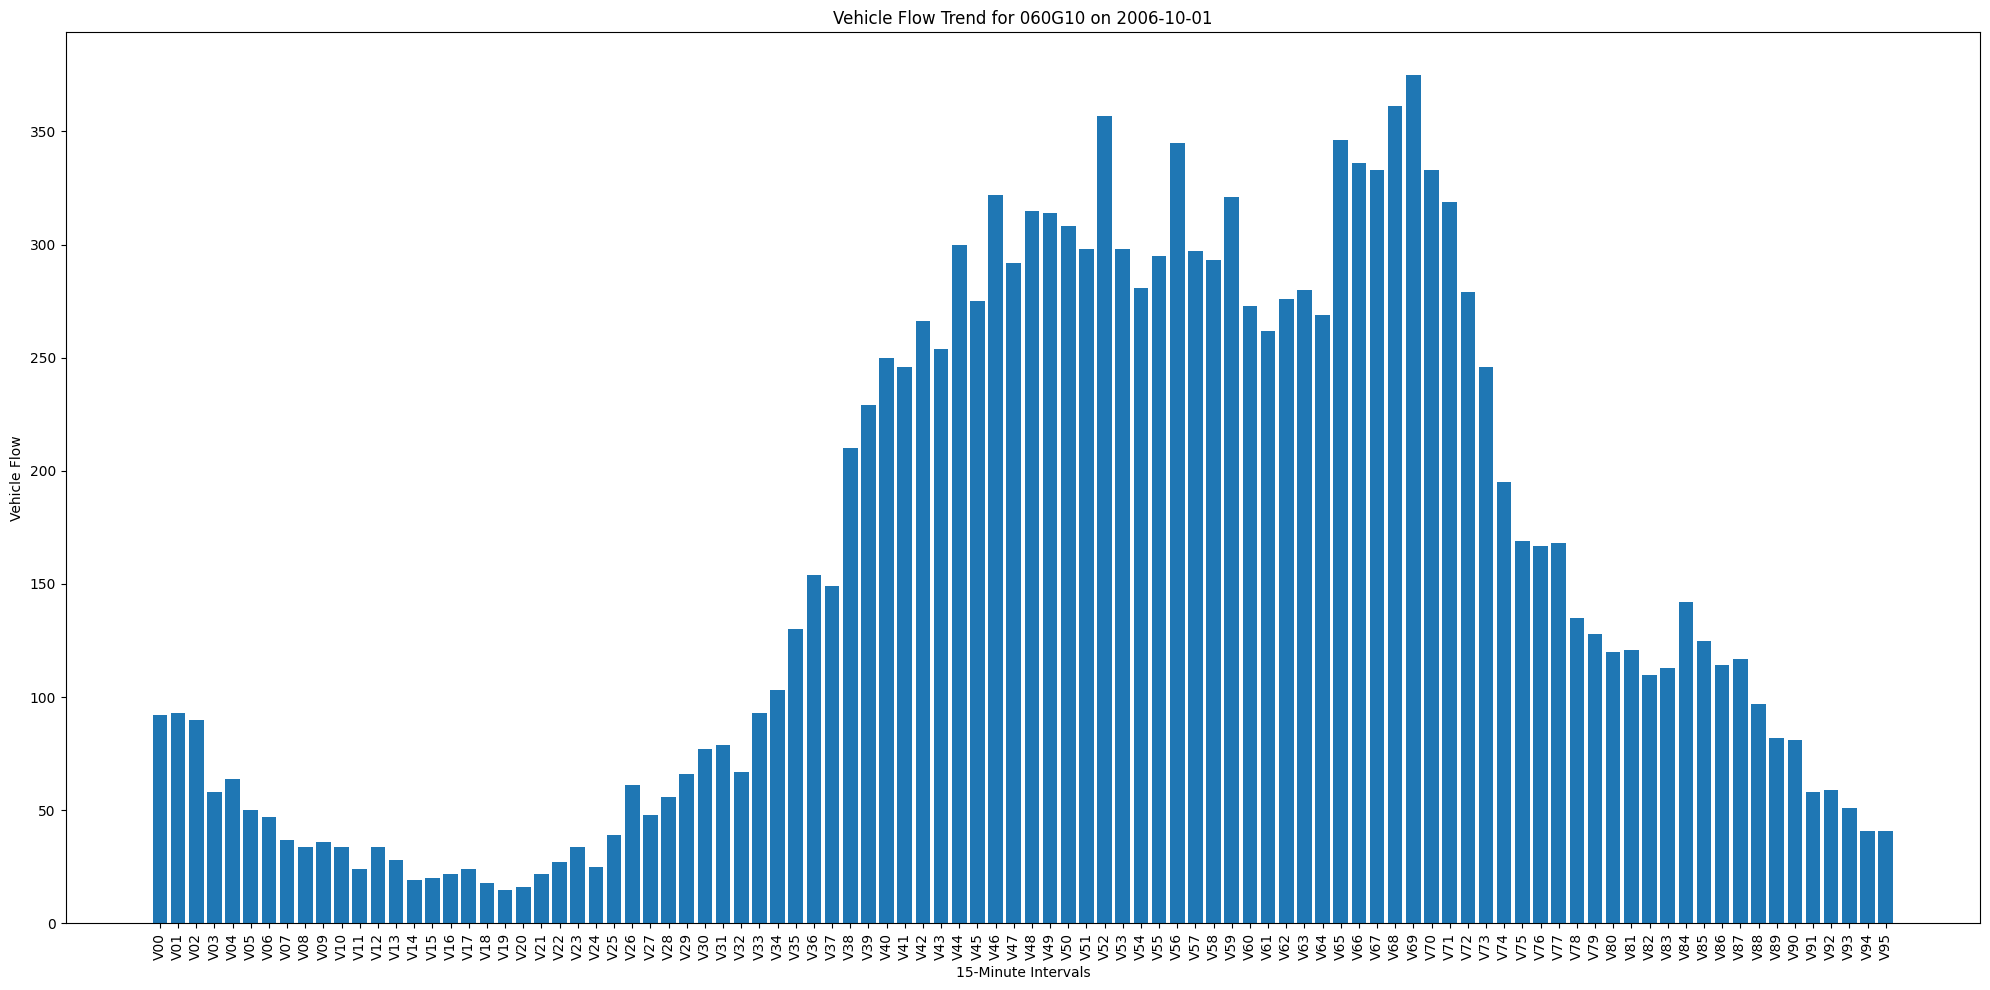

In [18]:
# It seems the previous session variables are not available, so let's reload the data and filtered dataframe

import pandas as pd
import matplotlib.pyplot as plt

# # Load the CSV file
# file_path = '/mnt/data/Out_9.csv'
# data = pd.read_csv(file_path)

# Convert 'Date' and 'Flow Vehicles' columns to appropriate data types
final_df_scats_october['Date'] = pd.to_datetime(final_df_scats_october['Date'], format='%d/%m/%y')
final_df_scats_october['Flow Vehicles'] = pd.to_numeric(final_df_scats_october['Flow Vehicles'], errors='coerce')

# Filtering criteria
selected_date = '2006-10-01'
selected_cd_melways = '060G10'

# Filter the data based on the selected date and CD_MELWAYS value
filtered_data = final_df_scats_october[(final_df_scats_october['Date'] == selected_date) & (final_df_scats_october['CD_MELWAYS'] == selected_cd_melways)]

# Re-plot the vehicle flow trend without point markers
# Re-plot the vehicle flow trend using a bar plot to avoid the straight line issue
plt.figure(figsize=(20, 10))
plt.bar(filtered_data['15_Minute_Intervals'], filtered_data['Flow Vehicles'])
plt.xlabel('15-Minute Intervals')
plt.ylabel('Vehicle Flow')
plt.title(f'Vehicle Flow Trend for {selected_cd_melways} on {selected_date}')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
# plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


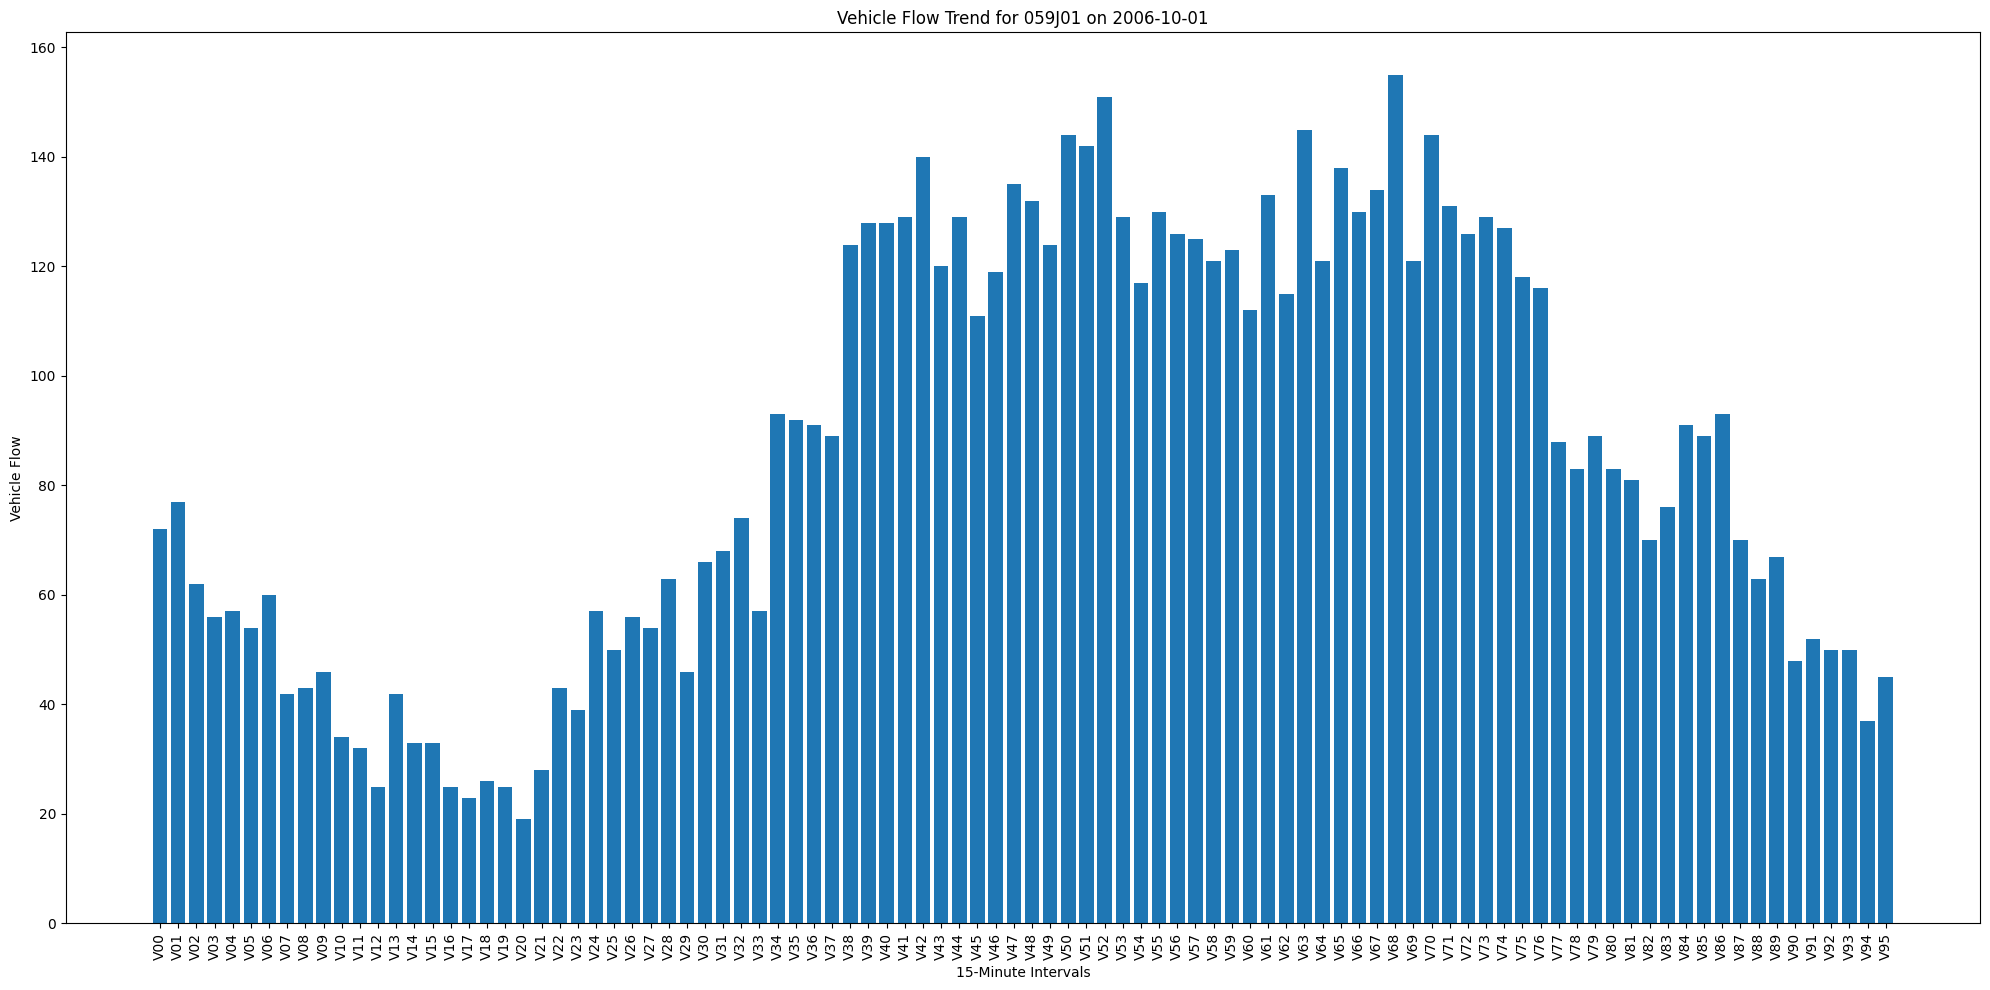

In [19]:
# Convert 'Date' and 'Flow Vehicles' columns to appropriate data types
final_df_scats_october['Date'] = pd.to_datetime(final_df_scats_october['Date'], format='%d/%m/%y')
final_df_scats_october['Flow Vehicles'] = pd.to_numeric(final_df_scats_october['Flow Vehicles'], errors='coerce')

# Filtering criteria
selected_date = '2006-10-01'
selected_cd_melways = '059J01'

# Filter the data based on the selected date and CD_MELWAYS value
filtered_data = final_df_scats_october[(final_df_scats_october['Date'] == selected_date) & (final_df_scats_october['CD_MELWAYS'] == selected_cd_melways)]

# Re-plot the vehicle flow trend without point markers
# Re-plot the vehicle flow trend using a bar plot to avoid the straight line issue
plt.figure(figsize=(20, 10))
plt.bar(filtered_data['15_Minute_Intervals'], filtered_data['Flow Vehicles'])
plt.xlabel('15-Minute Intervals')
plt.ylabel('Vehicle Flow')
plt.title(f'Vehicle Flow Trend for {selected_cd_melways} on {selected_date}')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
# plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show() 

In [24]:
df_scats_data_october

,SCATS Number,Location,CD_MELWAYS,NB_LATITUDE,NB_LONGITUDE,HF VicRoads Internal,VR Internal Stat,VR Internal Loc,NB_TYPE_SURVEY,Date,V00,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,Unnamed: 106,Unnamed: 107,Unnamed: 108
0,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,1/10/06,86,83,52,58,59,44,31,37,30,24,16,24,25,25,15,6,21,17,15,15,16,21,27,21,25,32,61,48,56,66,77,79,67,93,103,130,154,149,210,229,250,246,266,254,300,275,322,292,315,314,308,280,357,298,281,289,345,297,233,227,273,225,265,257,233,244,259,264,265,253,243,210,216,202,177,169,167,136,131,128,118,121,87,113,142,112,114,97,97,66,81,50,59,47,29,34,NaN,NaN,NaN
1,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,2/10/06,32,28,17,11,7,11,6,15,11,12,6,9,1,4,11,9,11,16,22,14,28,26,57,57,70,136,221,196,239,366,355,400,401,400,395,367,315,308,302,306,245,286,279,275,227,234,236,239,320,254,242,261,251,290,254,256,283,226,276,271,281,285,306,301,327,340,294,326,277,382,320,377,259,298,218,190,186,172,161,158,134,141,119,142,103,108,111,102,107,114,80,60,62,48,44,26,NaN,NaN,NaN
2,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,3/10/06,26,32,21,14,10,12,13,10,9,7,8,5,5,6,11,12,8,11,13,10,23,37,64,95,90,183,219,251,302,307,410,351,411,408,405,372,330,366,360,317,312,289,293,299,293,273,264,264,290,260,286,272,274,270,259,313,281,347,280,266,347,277,328,318,357,347,381,288,358,338,365,369,296,335,269,232,211,198,176,163,155,140,135,129,139,146,130,132,114,86,93,90,73,57,29,40,NaN,NaN,NaN
3,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,4/10/06,32,22,28,13,16,8,14,10,8,8,7,6,8,2,7,10,8,14,16,12,24,37,62,84,82,166,230,235,256,336,316,392,374,392,417,380,376,328,324,338,282,272,290,340,301,288,258,272,319,315,251,281,294,301,300,288,282,260,247,252,320,300,264,329,359,345,270,338,308,340,377,335,352,290,258,281,237,203,167,165,133,163,135,141,137,158,115,113,132,101,113,90,78,66,52,44,NaN,NaN,NaN
4,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,5/10/06,40,39,21,11,16,9,15,15,9,6,9,4,4,1,11,9,17,13,16,15,23,35,58,79,81,139,238,235,235,328,344,315,359,434,375,365,356,362,328,330,327,276,311,281,303,324,285,301,331,296,302,299,290,281,308,294,303,296,265,306,312,322,343,317,397,385,388,324,348,361,372,396,315,334,309,271,251,262,228,196,176,152,146,167,122,150,171,120,116,113,99,91,61,55,49,36,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,4821,VICTORIA_ST W OF BURNLEY_ST,002HF02,-37.81296,145.00830,6673,1513,7,1,27/10/06,51,56,43,29,35,19,24,21,15,20,19,14,16,15,13,14,11,15,14,21,17,22,34,51,36,66,109,103,113,136,138,141,218,174,167,168,166,146,163,142,170,158,173,147,194,173,186,151,206,199,218,197,201,197,232,206,205,212,194,215,224,229,253,223,240,261,305,268,303,270,333,264,341,255,214,229,224,204,150,189,164,167,115,133,127,122,122,121,127,103,122,124,117,99,108,88,NaN,NaN,NaN
4188,4821,VICTORIA_ST W OF BURNLEY_ST,002HF02,-37.81296,145.00830,6673,1513,7,1,28/10/06,91,87,89,72,64,81,58,47,52,43,33,47,36,37,27,24,23,35,26,15,16,25,27,24,29,30,38,55,57,50,80,96,79,74,105,110,129,140,154,184,176,163,196,188,193,191,219,224,200,240,223,236,225,200,226,222,216,223,227,219,221,211,236,218,235,242,220,177,201,185,175,154

In [26]:
lat_long_intersection

,Scats_number,Site description,Site Type,Latitude,Longitude,CD_MELWAYS,Neighbours
0,970,WARRIGAL/HIGH ST RD,INT,-37.867030,145.091590,060G10,3685
1,2000,BURWOOD HWY/WARRIGAL,INT,-37.851683,145.094346,060H06,3682;3685
2,2200,MAROONDAH/UNION,INT,-37.816310,145.098120,046H08,
3,2820,CHANDLER HWY/PRINCESS ST,INT,-37.794770,145.030770,045C02,
4,2825,EASTERN/BURKE ON RAMP,INT,-37.786610,145.062020,031K12,
5,2827,EASTERN FWY/BULLEEN/THOMPSONS,INT,-37.780930,145.077330,032D11,4051
6,2846,MONASH/HIGH/WILLS,INT,-37.861267,145.058038,059J09,3001
7,3001,BARKERS/CHURCH/HIGH,INT,-37.814410,145.022430,045A08,3002;4262;2846;3662
8,3002,BARKERS/DENMARK/POWER,INT,-37.814890,145.026630,045B08,4035;3001;3662;4263
9,3120,BURKE/CANTERBURY,INT,-37.822640,145.057340,045J10,4040;4035;3122
